# Boxplot of region specific ancestry-related DEGs

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(ggpubr)
})

## Functions

### Cached functions

In [2]:
get_biomart_df <- function(){
    biomart = data.table::fread("../_h/biomart.csv")
}
memMART <- memoise::memoise(get_biomart_df)

get_degs <- function(){
    mashr_file = "../../../mashr/_m/genes/lfsr_feature_4tissues.txt.gz"
    return(data.table::fread(mashr_file))
}
memDEG <- memoise::memoise(get_degs)

get_select_degs <- function(){
    geneids = c("NKAIN1", "LRRK1", "WIF1", "GRIN3A", "PDE1A", "EMX2OS", "PSPH", "PLRG1")
    gene_df = memDEG() %>% pivot_longer(-Effect, names_to="Tissue", values_to="lfsr") %>% 
        mutate(Tissue=gsub("\\.", " ", Tissue), ensembl_gene_id=gsub("\\..*", "", Effect)) %>% 
        inner_join(memMART(), by="ensembl_gene_id") %>% 
        filter(external_gene_name %in% geneids) %>% select(-V1, -description, -entrezgene) %>%
        mutate(New_ID=paste(external_gene_name, paste("lfsr:", signif(lfsr,2)), sep="\n")) %>%
        mutate_if(is.character, as.factor)
    return(gene_df)
}
memGENES <- memoise::memoise(get_select_degs)

get_residualized_df <- function(){
    expr_file = "../../_m/genes/residualized_expression.tsv"
    return(data.table::fread(expr_file) %>% 
               filter(Geneid %in% memGENES()$Effect) %>%
               column_to_rownames("Geneid"))
}
memRES <- memoise::memoise(get_residualized_df)


get_pheno_df <- function(){
    phenotype_file = paste0('../../../../../input/phenotypes/merged/_m/merged_phenotypes.csv')
    return(data.table::fread(phenotype_file) %>% select(RNum, Race, Region))
}
memPHENO <- memoise::memoise(get_pheno_df)

merge_dt <- function(){
    bigdf = memRES() %>% t %>% as.data.frame %>% rownames_to_column("RNum") %>%
        inner_join(memPHENO(), by="RNum") %>% 
        mutate(Race=gsub("CAUC", "EA", Race), 
               Region=gsub("HIPPO", "Hippocampus", Region), 
               Region=gsub("DentateGyrus", "Dentate Gyrus", Region)) %>%
        pivot_longer(-c(RNum, Race, Region), names_to="Geneid", values_to="Res") %>%
        inner_join(memGENES(), by=c("Geneid"="Effect"))
    return(bigdf)
}
memDF <- memoise::memoise(merge_dt)

### Simple functions

In [3]:
save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## Plot DEGs

### Group plot

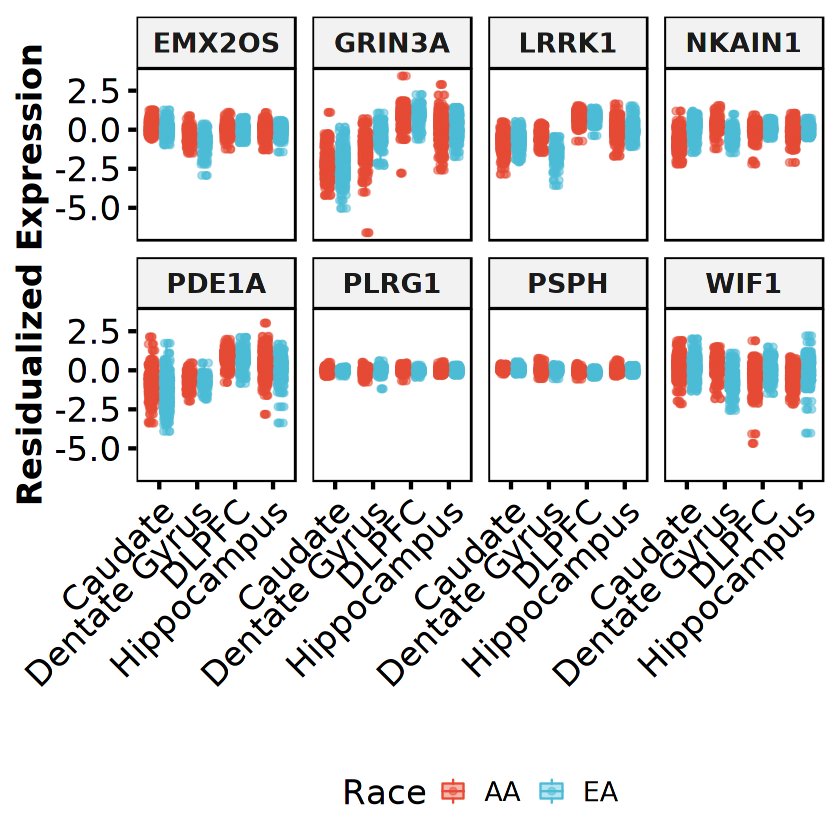

In [16]:
tissues = c("Caudate", "Dentate Gyrus", "DLPFC", "Hippocampus")
bxp = memDF() %>% mutate(Region = factor(Region, levels=c(tissues))) %>%
    ggboxplot(x="Region", y="Res", fill="Race", color="Race", add="jitter", 
              palette="npg", facet.by="external_gene_name", ncol=4, xlab="", 
              ylab="Residualized Expression", panel.labs.font=list(face='bold'),
              outlier.shape=NA, add.params=list(alpha=0.5), alpha=0.4, 
              legend="bottom", ggtheme=theme_pubr(base_size=20, border=TRUE)) +
    font("xy.title", face="bold") + rotate_x_text(45)
save_ggplots("boxplot_interaction_ancestry_degs", bxp, 10, 8)
bxp

### Individual genes

In [28]:
geneids = c("NKAIN1", "LRRK1", "WIF1", "GRIN3A", "PDE1A", "EMX2OS", "PSPH", "PLRG1")
for(geneid in geneids){
    dt = memDF() %>% filter(external_gene_name == geneid) 
    y1 = min(dt$Res) - 0.25; y2 = max(dt$Res) + 0.25
    bxp = dt %>% mutate(Region = factor(Region, levels=c(tissues))) %>%
        ggboxplot(x="Region", y="Res", fill="Race", color="Race", add="jitter", 
                  palette="npg", facet.by="external_gene_name", ncol=4, xlab="", 
                  ylab="Residualized Expression", panel.labs.font=list(face='bold'),
                  outlier.shape=NA, add.params=list(alpha=0.5), alpha=0.4,
                  ylim=c(y1, y2), ggtheme=theme_pubr(base_size=20, border=TRUE),
                  legend="bottom") +
        font("xy.title", face="bold") + rotate_x_text(45)
    save_ggplots(paste0("boxplot_interaction_ancestry_",geneid), bxp, 4, 6)
}

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()